In [36]:
import opendatasets as od
import os

In [37]:
dataset_url = 'https://www.kaggle.com/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification'
data_dir = 'cats-vs-dogs-vs-birds-audio-classification'
od.download(dataset_url)
os.listdir(data_dir)

Skipping, found downloaded files in "./cats-vs-dogs-vs-birds-audio-classification" (use force=True to force download)


['Animals']

In [38]:
!pip install scikit-image

In [39]:
import torch
from torch import nn
from model import Net
from Dataset import CustomAudioDataset
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import time

In [40]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

In [41]:
audio_paths = []
labels = []

for label in os.listdir(os.path.join(data_dir, 'Animals')):  # label is cat, dog, bird
    label_path = os.path.join(os.path.join(data_dir, 'Animals'), label)
    for audio in os.listdir(label_path):
        labels.append(label)
        audio_paths.append(os.path.join(label_path, audio))

data_df = pd.DataFrame({'FilePath': audio_paths, 'Class': labels})

Data Shape is: (610, 2)

Classes Distribution 



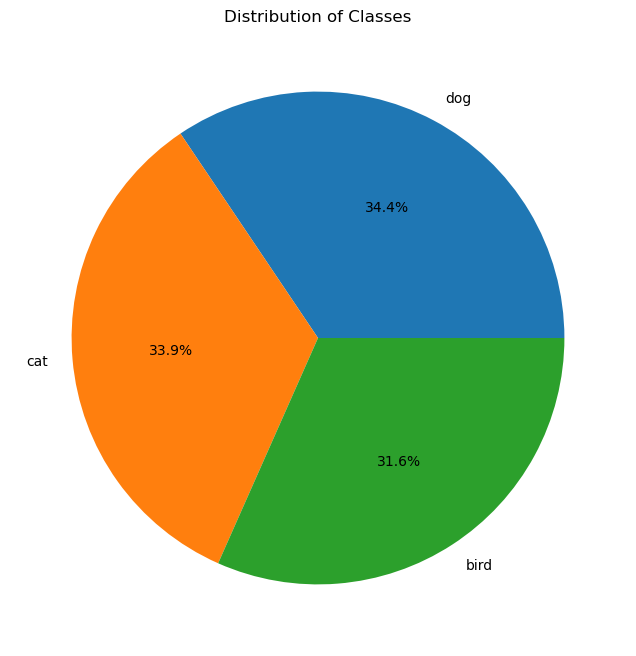

In [42]:
print(f'Data Shape is: {data_df.shape }\n')
print('Classes Distribution \n')

class_counts = data_df['Class'].value_counts()
plt.figure(figsize=(8,8))

plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.show()

In [43]:
label_encoder = LabelEncoder()
data_df['class'] = label_encoder.fit_transform(data_df['Class'])

train_dataset = data_df.sample(frac=0.7, random_state=42).reset_index(drop=True)
test_dataset = data_df.drop(train_dataset.index).reset_index(drop=True)

val_dataset = test_dataset.sample(frac=0.5, random_state=42).reset_index(drop=True)
test_dataset = test_dataset.drop(val_dataset.index).reset_index(drop=True)

print(f'Training Dataset Shape {train_dataset.shape}')
print(f'Validation Dataset Shape {val_dataset.shape}')
print(f'Test Dataset Shape {test_dataset.shape}')

Training Dataset Shape (427, 3)
Validation Dataset Shape (92, 3)
Test Dataset Shape (91, 3)


In [44]:
!pip install librosa --quiet

In [45]:
train_set = CustomAudioDataset(dataframe=train_dataset)
test_set = CustomAudioDataset(dataframe=test_dataset)
val_set = CustomAudioDataset(dataframe=val_dataset)

In [46]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [47]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [48]:
num_classes = len(data_df['Class'].unique())
model = Net(num_classes=num_classes).to(device)
model_cpu = Net(num_classes=num_classes).to('cpu')

In [49]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model_cpu.apply(init_weights)

Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (se_block): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Conv2d(64, 4, kernel_size=(1

In [50]:
from torchsummary import summary
summary(model_cpu, (1, 128, 256)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
       BatchNorm2d-2         [-1, 16, 128, 256]              32
              ReLU-3         [-1, 16, 128, 256]               0
         MaxPool2d-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
       BatchNorm2d-6          [-1, 32, 64, 128]              64
              ReLU-7          [-1, 32, 64, 128]               0
         MaxPool2d-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
      BatchNorm2d-10           [-1, 64, 32, 64]             128
             ReLU-11           [-1, 64, 32, 64]               0
        MaxPool2d-12           [-1, 64, 16, 32]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Conv2d-14              [-1, 

In [51]:
criterion = nn.CrossEntropyLoss() 
optimizer = Adam(model.parameters(), lr=LR) 

In [52]:
print(len(train_dataset), len(train_dataset.FilePath), len(train_dataset.Class))

427 427 427


In [53]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    model.train()
    start_time = time.time()
    
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        
        loss.backward()
        optimizer.step()


    model.eval()
    
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_accuracy = correct_train / total_train * 100
    val_accuracy = correct_val / total_val * 100

    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_loss_validation_plot.append(round(avg_val_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))
    total_acc_validation_plot.append(round(val_accuracy, 4))

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    print("="*40)

Epoch [1/25] | Train Loss: 1.2214, Train Acc: 45.90% | Val Loss: 0.6434, Val Acc: 76.09%
Epoch [2/25] | Train Loss: 0.7357, Train Acc: 66.04% | Val Loss: 0.3614, Val Acc: 94.57%
Epoch [3/25] | Train Loss: 0.6455, Train Acc: 74.94% | Val Loss: 0.2356, Val Acc: 94.57%
Epoch [4/25] | Train Loss: 0.5401, Train Acc: 78.69% | Val Loss: 0.2257, Val Acc: 96.74%
Epoch [5/25] | Train Loss: 0.4422, Train Acc: 80.33% | Val Loss: 0.2553, Val Acc: 93.48%
Epoch [6/25] | Train Loss: 0.4346, Train Acc: 82.67% | Val Loss: 0.2155, Val Acc: 94.57%
Epoch [7/25] | Train Loss: 0.3479, Train Acc: 86.42% | Val Loss: 0.2062, Val Acc: 94.57%
Epoch [8/25] | Train Loss: 0.3084, Train Acc: 87.59% | Val Loss: 0.1247, Val Acc: 96.74%
Epoch [9/25] | Train Loss: 0.2592, Train Acc: 91.33% | Val Loss: 0.1985, Val Acc: 94.57%
Epoch [10/25] | Train Loss: 0.2519, Train Acc: 89.93% | Val Loss: 0.1715, Val Acc: 96.74%
Epoch [11/25] | Train Loss: 0.1729, Train Acc: 92.74% | Val Loss: 0.1450, Val Acc: 96.74%
Epoch [12/25] | Tra

In [54]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):
    input = input.to(device)
    labels = labels.to(device)
    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 98.9%


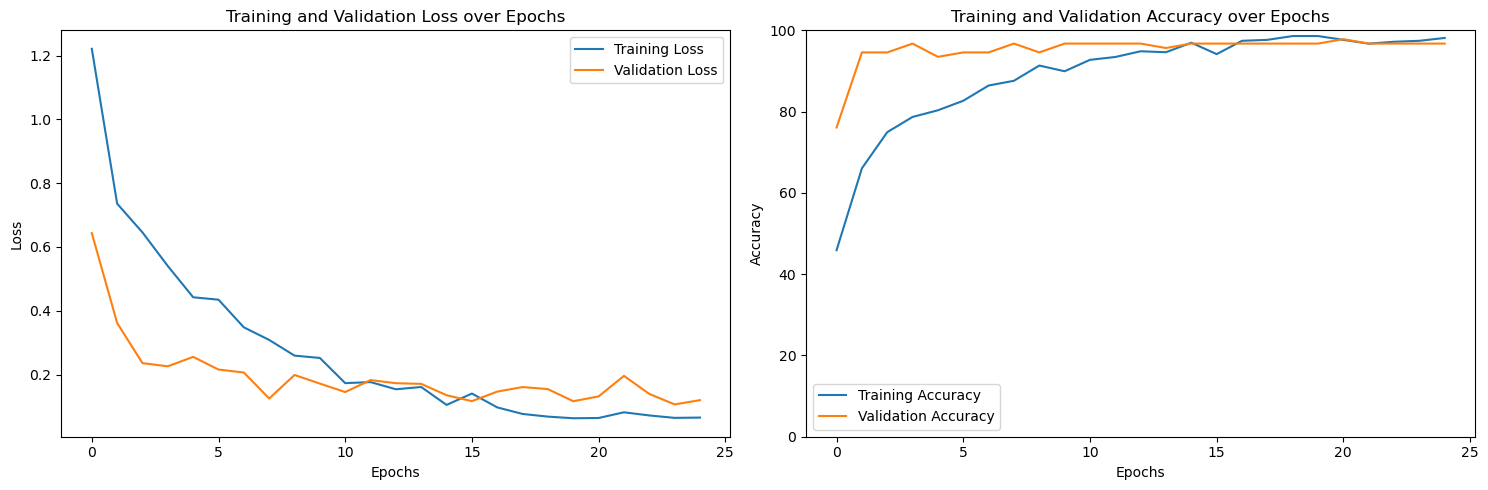

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [56]:
torch.save(model.state_dict(), 'best_model.pth')

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

model = Net(num_classes=3).to(device)
model.load_state_dict(torch.load("best_model.pth", weights_only=False))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Classification Report:
              precision    recall  f1-score   support

        bird       1.00      0.99      0.99        91
         cat       0.00      0.00      0.00         0
         dog       0.00      0.00      0.00         0

   micro avg       0.99      0.99      0.99        91
   macro avg       0.33      0.33      0.33        91
weighted avg       1.00      0.99      0.99        91



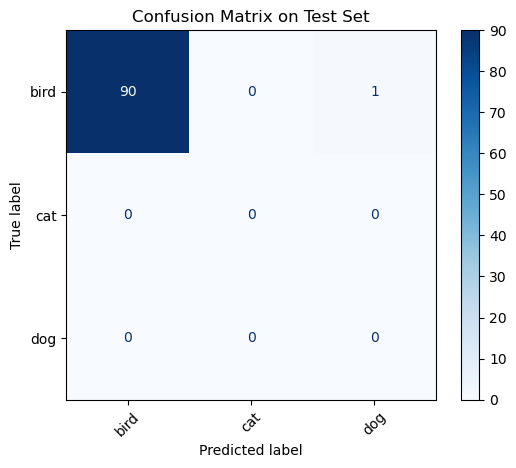

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

target_names = label_encoder.classes_
label_ids = list(range(len(target_names)))  # [0, 1, 2]

print("Classification Report:")
print(classification_report(all_labels, all_preds,
                            target_names=target_names,
                            labels=label_ids,
                            zero_division=0))

cm = confusion_matrix(all_labels,
                      all_preds,
                      labels=label_ids)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=target_names)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()
